In [1]:
#!pip install mediapipe

# Dependencias importadas

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


import torch
from torch.utils.data import Dataset
from torchvision import transforms
from transformers import AutoImageProcessor
from transformers import ViTForImageClassification, ViTImageProcessor



import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch.nn.functional as F
from PIL import Image




2025-11-03 17:58:33.065821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762192713.298874      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762192713.362053      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Variables globales 

In [3]:
# GLOBAL VARIABLES
img_size = (224, 224)
batch_size = 8
train_location = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
train_location_small = '/kaggle/input/asl-alphabet-test'
test_location = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'

SEED = 42
TOTAL_IMAGES = 20000

# Transformer


## Cargamos el data set para la parte de train

In [4]:
# Balanceamos el dataset

class_names = sorted(os.listdir(train_location))
num_classes = len(class_names)
images_per_class = TOTAL_IMAGES // num_classes 
balanced_file_paths = []
balanced_labels = []

for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(train_location, class_name)
    all_images = os.listdir(class_dir)
    
    # Tomar aleatoriamente images_per_class (≈689) de los ~3000 disponibles
    selected_images = random.sample(all_images, images_per_class)
    
    balanced_file_paths.extend([os.path.join(class_dir, img) for img in selected_images])
    balanced_labels.extend([idx] * images_per_class)

# Mezclar aleatoriamente
combined = list(zip(balanced_file_paths, balanced_labels))
random.shuffle(combined)
balanced_file_paths, balanced_labels = zip(*combined)


# Transformaciones y Feature Extractor

feature_extractor = AutoImageProcessor.from_pretrained(
    "google/vit-base-patch16-224-in21k", use_fast=True
)

train_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),  # convierte [0,255] -> [0,1]
])

# Dataset Pytorch para el modelo

class TorchBalancedDataset(Dataset):
    def __init__(self, file_paths, labels, feature_extractor, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]

        # Cargar imagen
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Feature extractor ViT
        pixel_values = self.feature_extractor(
            images=image, return_tensors="pt", do_rescale=False
        ).pixel_values.squeeze()

        return {"pixel_values": pixel_values, "labels": torch.tensor(label)}


# Instanciamos el dataset

train_dataset = TorchBalancedDataset(
    balanced_file_paths, balanced_labels, feature_extractor, transform=train_transform
)

print(f"Dataset listo con {len(train_dataset)} imágenes y {num_classes} clases.")





class TorchTestDataset(Dataset):
    def __init__(self, file_paths, feature_extractor, transform=None):
        self.file_paths = file_paths
        self.feature_extractor = feature_extractor
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        pixel_values = self.feature_extractor(
            images=image, return_tensors="pt", do_rescale=False
        ).pixel_values.squeeze()
        return {"pixel_values": pixel_values}


# Listado de archivos de test

test_files = [os.path.join(test_location, f)
              for f in os.listdir(test_location)
              if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Instanciar dataset de test

test_dataset = TorchTestDataset(
    test_files, feature_extractor, transform=train_transform
)

print(f"Test dataset listo con {len(test_dataset)} imágenes.")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Dataset listo con 19981 imágenes y 29 clases.
Test dataset listo con 28 imágenes.


In [5]:
# CARGAR DATASET DE TEST más grande

test_file_paths = []
test_labels = []

for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(train_location_small, class_name)  # ruta a tus subcarpetas por clase
    if not os.path.exists(class_dir):
        print(f"Carpeta no encontrada en test: {class_name}")
        continue

    all_images = os.listdir(class_dir)
    test_file_paths.extend([os.path.join(class_dir, img) for img in all_images])
    test_labels.extend([idx] * len(all_images))

# Crear dataset PyTorch con todas las imágenes del test
test_dataset2 = TorchBalancedDataset(
    test_file_paths, test_labels, feature_extractor, transform=train_transform
)

print(f"Dataset de prueba listo con {len(test_dataset2)} imágenes distribuidas en {len(class_names)} clases.")


Dataset de prueba listo con 870 imágenes distribuidas en 29 clases.


In [6]:
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


## Cargamos el modelo 

In [7]:
# Descargamos el modelo ViT y feature extractor


num_labels = len(class_names)

# Feature extractor
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Modelo ViT para clasificación
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_labels,
    ignore_mismatched_sizes=True  # importante para transfer learning
)

# Uso de la grafica
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"Modelo cargado en: {device}")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo cargado en: cuda


In [8]:


from transformers import Trainer, TrainingArguments


# Entrenamiento 

training_args = TrainingArguments(
    output_dir="./vit_asl_model",
    per_device_train_batch_size=8, 
    num_train_epochs=4,
    learning_rate=5e-5,
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    remove_unused_columns=False,
    report_to="none",
    fp16=True, 
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

print("Dataset y Trainer listos para entrenamiento.")


Dataset y Trainer listos para entrenamiento.


In [9]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
50,2.434000
100,0.765500
150,0.205300
200,0.104100
250,0.039400
300,0.032400
350,0.012600
400,0.019400
450,0.023000
500,0.012300


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=4996, training_loss=0.03948726107945616, metrics={'train_runtime': 2217.1582, 'train_samples_per_second': 36.048, 'train_steps_per_second': 2.253, 'total_flos': 6.194968550943105e+18, 'train_loss': 0.03948726107945616, 'epoch': 4.0})


 Predicciones del modelo sobre el test set:
Imagen 1: Letra predicha → A
Imagen 2: Letra predicha → E
Imagen 3: Letra predicha → L
Imagen 4: Letra predicha → N
Imagen 5: Letra predicha → S
Imagen 6: Letra predicha → D
Imagen 7: Letra predicha → G
Imagen 8: Letra predicha → I
Imagen 9: Letra predicha → W
Imagen 10: Letra predicha → M
Imagen 11: Letra predicha → nothing
Imagen 12: Letra predicha → X
Imagen 13: Letra predicha → H
Imagen 14: Letra predicha → Q
Imagen 15: Letra predicha → C
Imagen 16: Letra predicha → T
Imagen 17: Letra predicha → P
Imagen 18: Letra predicha → V
Imagen 19: Letra predicha → Y
Imagen 20: Letra predicha → U


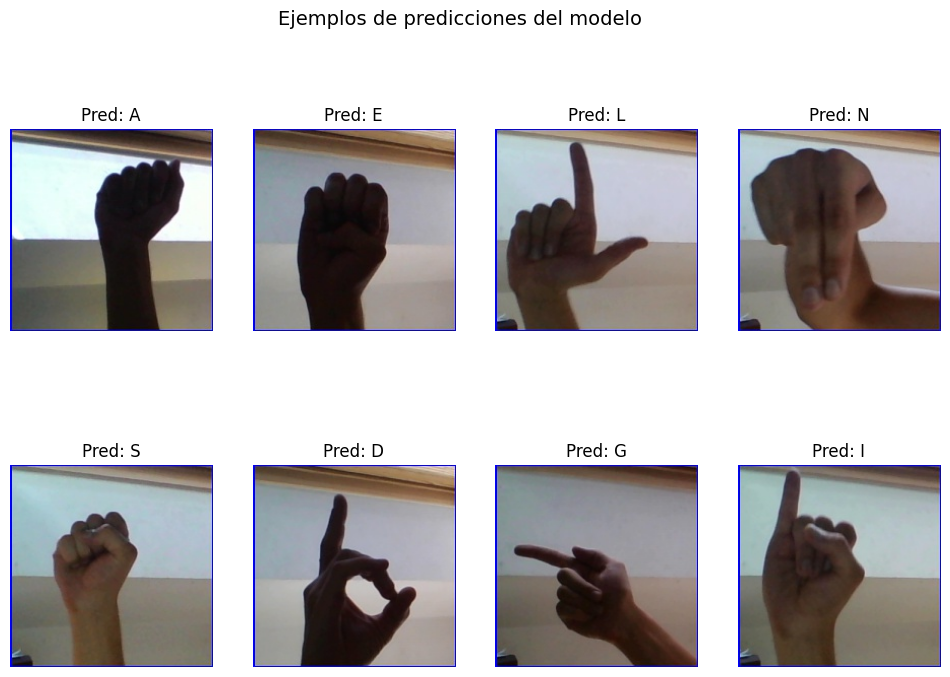

In [10]:

# Ponemos el modelo en modo evaluación
model.eval()

# Contenedor para predicciones
pred_labels = [] 
# Realizar inferencia sobre el test dataset 
with torch.no_grad():
    for sample in test_dataset:
        pixel_values = sample["pixel_values"].unsqueeze(0).to(device) 
        outputs = model(pixel_values)
        pred = torch.argmax(outputs.logits, dim=-1).item()
        pred_labels.append(pred)
        # Mapeamos los índices a los nombres de la clase 
pred_class_names = [class_names[idx] for idx in pred_labels]
# Mostrar resultados mapeados de manera clara 
print("\n Predicciones del modelo sobre el test set:")
for i, pred in enumerate(pred_class_names[:20]): 
    # muestra solo las primeras 20 predicciones 
    print(f"Imagen {i+1}: Letra predicha → {pred}")


# Muestra de algunas predicciones

sample_files = test_files[:8]
sample_images = [Image.open(f).convert("RGB") for f in sample_files]
sample_inputs = feature_extractor(images=sample_images, return_tensors="pt").to(device)

with torch.no_grad():
    sample_outputs = model(**sample_inputs)
    sample_preds = torch.argmax(sample_outputs.logits, dim=-1).cpu().numpy()

# Mapear índices a nombres de clase
sample_class_names = [class_names[i] for i in sample_preds]

plt.figure(figsize=(12, 8))
for i, img in enumerate(sample_images):
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {sample_class_names[i]}")
plt.suptitle("Ejemplos de predicciones del modelo", fontsize=14)
plt.show()


In [11]:

#  Crear DataLoader para el dataset de test
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset2, batch_size=16, shuffle=False)

# Inferencia
pred_labels = []
true_labels_all = []
with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)
        pred_labels.extend(preds.cpu().numpy())
        true_labels_all.extend(labels.cpu().numpy())



Accuracy total del modelo: 0.8540

Reporte de Clasificación:
              precision    recall  f1-score   support

           A       0.96      0.90      0.93        30
           B       1.00      1.00      1.00        30
           C       0.86      0.83      0.85        30
           D       0.83      1.00      0.91        30
           E       0.86      0.83      0.85        30
           F       1.00      0.83      0.91        30
           G       0.93      0.93      0.93        30
           H       0.94      0.97      0.95        30
           I       0.76      0.97      0.85        30
           J       0.77      1.00      0.87        30
           K       0.46      0.97      0.62        30
           L       0.88      0.97      0.92        30
           M       0.63      0.90      0.74        30
           N       0.82      0.47      0.60        30
           O       0.87      0.90      0.89        30
           P       0.97      1.00      0.98        30
           Q       

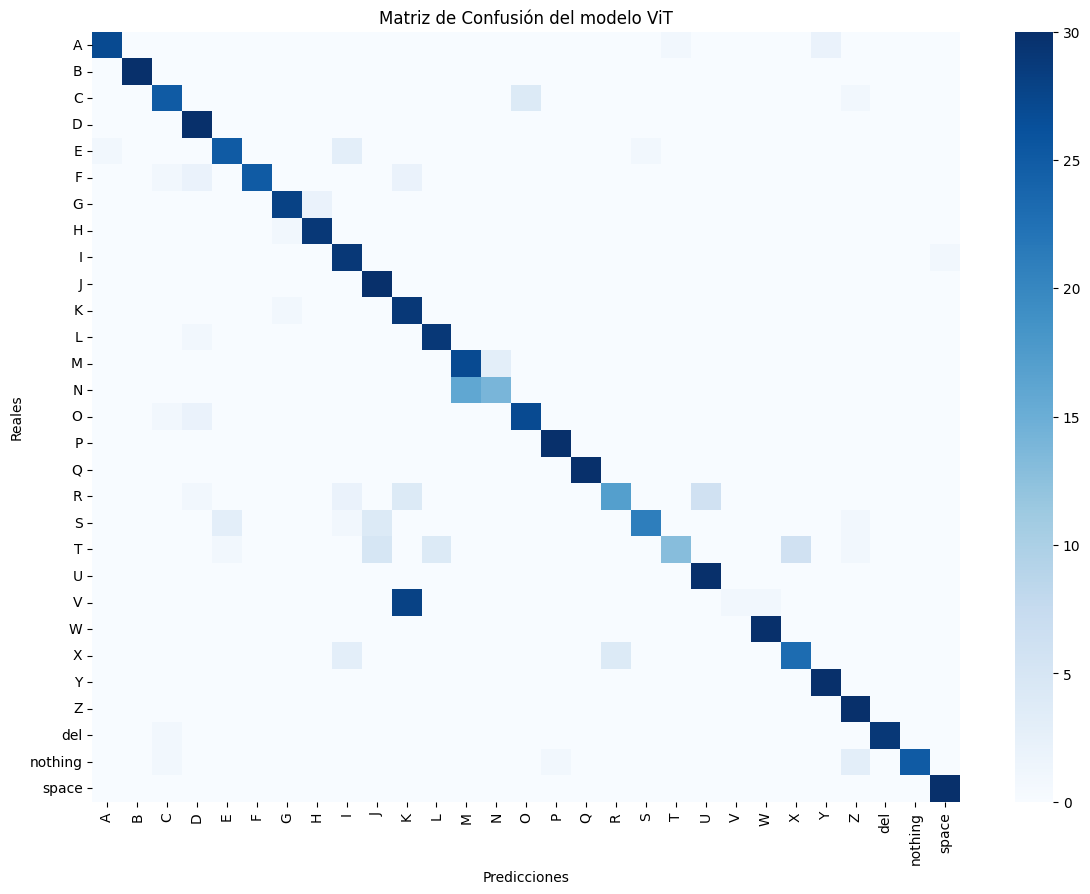

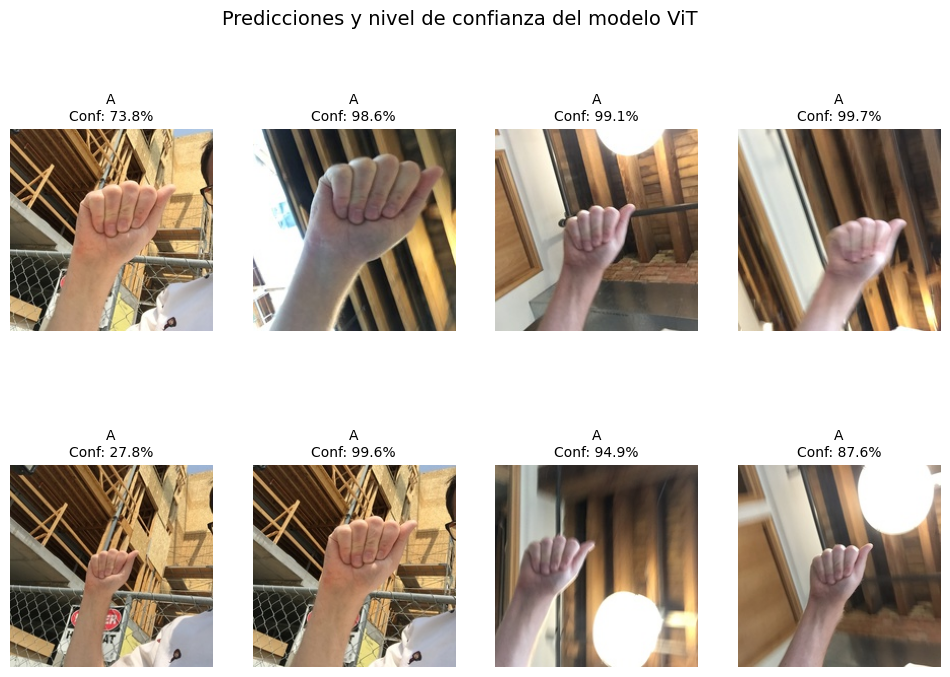


Predicciones del modelo sobre el test set:
Imagen 1: Letra predicha → A
Imagen 2: Letra predicha → A
Imagen 3: Letra predicha → A
Imagen 4: Letra predicha → A
Imagen 5: Letra predicha → A
Imagen 6: Letra predicha → A
Imagen 7: Letra predicha → A
Imagen 8: Letra predicha → A
Imagen 9: Letra predicha → A
Imagen 10: Letra predicha → A
Imagen 11: Letra predicha → A
Imagen 12: Letra predicha → A
Imagen 13: Letra predicha → A
Imagen 14: Letra predicha → A
Imagen 15: Letra predicha → A
Imagen 16: Letra predicha → A
Imagen 17: Letra predicha → A
Imagen 18: Letra predicha → A
Imagen 19: Letra predicha → A
Imagen 20: Letra predicha → Y


In [12]:


# Métricas y reporte

if len(true_labels_all) > 0 and len(pred_labels) == len(true_labels_all):
    acc = accuracy_score(true_labels_all, pred_labels)
    print(f"\nAccuracy total del modelo: {acc:.4f}")
    print("\nReporte de Clasificación:")
    print(classification_report(true_labels_all, pred_labels, target_names=class_names))

    cm = confusion_matrix(true_labels_all, pred_labels)
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Matriz de Confusión del modelo ViT")
    plt.xlabel("Predicciones")
    plt.ylabel("Reales")
    plt.show()
else:
    print("No se encontraron etiquetas verdaderas o la longitud no coincide; solo se mostrarán predicciones.")


# Visualización de algunas predicciones con confianza

sample_files = test_file_paths[:8]

if len(sample_files) == 0:
    print("No hay imágenes para mostrar en la visualización.")
else:
    sample_images = [Image.open(f).convert("RGB") for f in sample_files]
    sample_inputs = feature_extractor(images=sample_images, return_tensors="pt")
    sample_inputs = {k: v.to(device) for k, v in sample_inputs.items()}

    with torch.no_grad():
        sample_outputs = model(**sample_inputs)
        probs = F.softmax(sample_outputs.logits, dim=-1)
        confidences, preds = torch.max(probs, dim=-1)

    plt.figure(figsize=(12, 8))
    for i, img in enumerate(sample_images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{class_names[preds[i]]}\nConf: {confidences[i]*100:.1f}%", fontsize=10)
    plt.suptitle("Predicciones y nivel de confianza del modelo ViT", fontsize=14)
    plt.show()


# Primeras predicciones detalladas

if len(pred_labels) > 0:
    print("\nPredicciones del modelo sobre el test set:")
    for i, pred in enumerate(pred_labels[:20]):
        print(f"Imagen {i+1}: Letra predicha → {class_names[pred]}")
else:
    print("No hay predicciones para mostrar.")
